### Projeto NLP : Análise de reviews do jogo The Last Of Us 2
fonte dos dados: https://www.kaggle.com/datasets/lazaro97/the-last-of-us-reviews

In [2]:
# importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image


In [3]:
! pip install WordCloud


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from wordcloud import WordCloud

In [5]:
# Pegando os dados
ds = pd.read_csv('./dados/user_reviews_g2.csv')

# Definindo as stopwords
stopwords = ['videogame','game','play','player','character','tlou','tlou2', 'neil','druckmann','naughty','dog','nc',
 'aaa', 'na','youtube', 'youtuber','f','h','ng']

In [6]:
# Visualizando os dados
ds.head()

,id,review,type_review,date,language,views,votes,score
0,Maksim_ON,"Продовження культової серії, було зіпсоване че...",expanded,2021-03-17,Ukrainian,2,2,2
1,Araset,"Well, it's most definetly sheeet and peess and...",expanded,2021-03-16,English,2,2,1
2,realistyalanci,"Pathetic.,Disappointment. Inconsistency.,Cring...",expanded,2021-03-16,English,3,3,0
3,Cliente,A maior traição que eu já vi na minha vida do ...,normal,2021-03-15,Portuguese,3,3,0
4,wingZero21,I really enjoyed the first game. It was a 10/1...,normal,2021-03-14,English,2,2,6


In [7]:
# Lexicons
afinn = pd.read_csv('./lexicons/Afinn.csv',index_col=0, encoding='latin-1')
bing = pd.read_csv('./lexicons/Bing.csv',index_col=0)
nrc = pd.read_csv('./lexicons/NRC.csv',index_col=0)
loug = pd.read_csv('./lexicons/Loughran.csv',index_col=0)

### Análise exploratória

Explicando variáveis: 
* Review: o review do usuario
* Type_review: alguns comentários são grandes ou são spoilers. Expandido é isso e normal é o resto
* Date: data que a review foi publicada
* Language: lingua que a review foi publicada 
* Views: número de views da review
* Votes: número de votos da review
* Score: proposta de pontuação dada pelo usuário. 


In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30665 entries, 0 to 30664
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           30665 non-null  object
 1   review       30657 non-null  object
 2   type_review  30665 non-null  object
 3   date         30665 non-null  object
 4   language     30665 non-null  object
 5   views        30665 non-null  int64 
 6   votes        30665 non-null  int64 
 7   score        30665 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


In [9]:
ds.columns

Index(['id', 'review', 'type_review', 'date', 'language', 'views', 'votes',
       'score'],
      dtype='object')

In [10]:
ds.shape

(30665, 8)

In [11]:
ds.dtypes

id             object
review         object
type_review    object
date           object
language       object
views           int64
votes           int64
score           int64
dtype: object

In [12]:
score = ds['score'].value_counts()
print(score)

10    11148
0      8353
1      2941
9      2045
2      1688
3      1292
4      1068
8       880
5       565
7       379
6       306
Name: score, dtype: int64


<AxesSubplot: title={'center': 'Score'}>

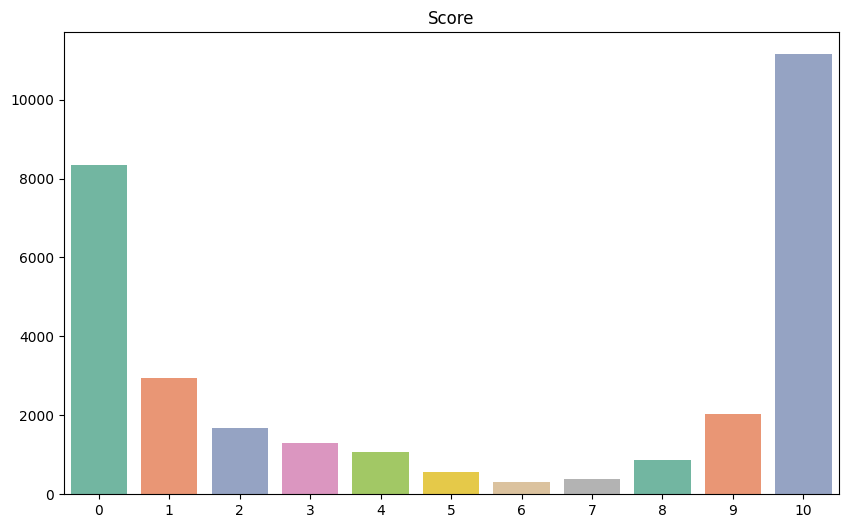

In [13]:
x = score.keys().to_list()
y = score.values.tolist()
plt.figure(figsize=(10,6))
plt.title("Score")
sns.barplot(x=x, y=y, palette="Set2")

Vemos que os reviews possuem grande valor em zero e em 10. O jogo foi marcado por ter reviews controversas dos usuários, por isso possuem esse valor expressivo de reviews positivos e negativos. 

Visualizando quais os idiomas possuem o maior número de reviews

In [14]:
ds['language'].value_counts()

English           24209
Spanish            2496
Portuguese         1492
Russian            1482
Italian             152
German              115
French              106
Korean               88
Turkish              70
Not identified       60
Somali               48
Polish               46
Arabic               32
Afrikaans            19
Danish               18
Welsh                16
Dutch                15
Norwegian            15
Indonesian           14
Estonian             14
Persian              13
Finnish              13
Czech                11
Catalan              11
Ukrainian            11
Tagalog              11
Hungarian            11
Slovenian            11
Vietnamese           10
Croatian              9
Albanian              7
Japanese              6
Romanian              6
Bulgarian             6
Swedish               5
Slovak                4
Macedonian            3
Lithuanian            3
Thai                  3
Swahili               2
Latvian               1
Hindi           

In [15]:
temp=ds.language.value_counts().iloc[:5]

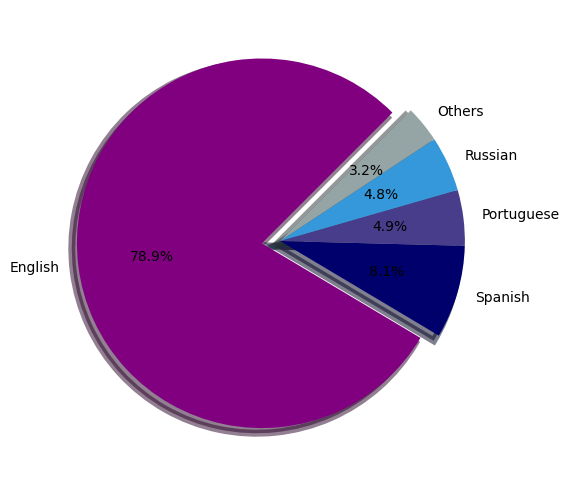

In [16]:
temp.index=['English', 'Spanish', 'Portuguese', 'Russian','Others']
temp.iloc[4]=ds.language.value_counts().iloc[4:].sum()
my_colors = [ 'purple','#00006c','#483d8b', "#3498db", "#95a5a6","#34495e"]
plt.figure(figsize = (6,6))
plt.pie(temp.values,labels=temp.keys(),autopct = '%1.1f%%',colors=my_colors,
        explode=[0.1,0,0,0,0],startangle=45,shadow=True,wedgeprops = {'linewidth': 5})
plt.show()

In [17]:
# Visualizando uma review
ds.review[1]

"Well, it's most definetly sheeet and peess and coom, and not a good game at all"

#### Limpeza

In [18]:
ds.isna().sum()

id             0
review         8
type_review    0
date           0
language       0
views          0
votes          0
score          0
dtype: int64

In [19]:
ds.fillna('',inplace=True)

In [20]:
ds['sug'] = ds.votes/ds.views

In [21]:
def Rating(number): 
    if number>7: return 'Excellent review'
    elif number<3: return 'Bad review'
    else: return 'Ok review'

In [22]:
ds['label']=ds.score.apply(Rating)

In [23]:
# aplicando tratamentos de datatime
ds['date']=ds.date.astype('datetime64[ns]')
ds['month']=ds.date.apply(lambda x: x.strftime("%B"))
ds['day_of_month']=ds.date.apply(lambda x: x.strftime("%d"))
ds['day_of_week']=ds.date.apply(lambda x: x.strftime("%A"))

In [24]:
# nova coluna para o tamanho da review
ds['review_length'] = ds.review.apply(len)

In [25]:
# Visualizando alterações
ds.head()

,id,review,type_review,date,language,views,votes,score,sug,label,month,day_of_month,day_of_week,review_length
0,Maksim_ON,"Продовження культової серії, було зіпсоване че...",expanded,2021-03-17,Ukrainian,2,2,2,1.0,Bad review,March,17,Wednesday,66
1,Araset,"Well, it's most definetly sheeet and peess and...",expanded,2021-03-16,English,2,2,1,1.0,Bad review,March,16,Tuesday,79
2,realistyalanci,"Pathetic.,Disappointment. Inconsistency.,Cring...",expanded,2021-03-16,English,3,3,0,1.0,Bad review,March,16,Tuesday,117
3,Cliente,A maior traição que eu já vi na minha vida do ...,normal,2021-03-15,Portuguese,3,3,0,1.0,Bad review,March,15,Monday,1427
4,wingZero21,I really enjoyed the first game. It was a 10/1...,normal,2021-03-14,English,2,2,6,1.0,Ok review,March,14,Sunday,2473


In [26]:
# pegando apenas reviews em ingles
dat=ds[ds.language=='English'].reset_index(drop=True)

In [27]:
dat.head()

,id,review,type_review,date,language,views,votes,score,sug,label,month,day_of_month,day_of_week,review_length
0,Araset,"Well, it's most definetly sheeet and peess and...",expanded,2021-03-16,English,2,2,1,1.0,Bad review,March,16,Tuesday,79
1,realistyalanci,"Pathetic.,Disappointment. Inconsistency.,Cring...",expanded,2021-03-16,English,3,3,0,1.0,Bad review,March,16,Tuesday,117
2,wingZero21,I really enjoyed the first game. It was a 10/1...,normal,2021-03-14,English,2,2,6,1.0,Ok review,March,14,Sunday,2473
3,echo360calix,This game is a very sad destruction of an amaz...,normal,2021-03-14,English,2,2,0,1.0,Bad review,March,14,Sunday,421
4,sa674,"It’s a different game from part one, not bad o...",expanded,2021-03-13,English,2,2,2,1.0,Bad review,March,13,Saturday,110


### Processamento de texto

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import plot_confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression

/var/folders/sw/vbxks35n4tzby0_9v7yr4gr40000gn/T/ipykernel_5769/3637707845.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dat.target=dat.score.apply(lambda x: 0 if x<5 else 1)


Dimenções: (24209, 14)
0.9166349951991764
0.8972525372962307


/Users/alessasantos/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


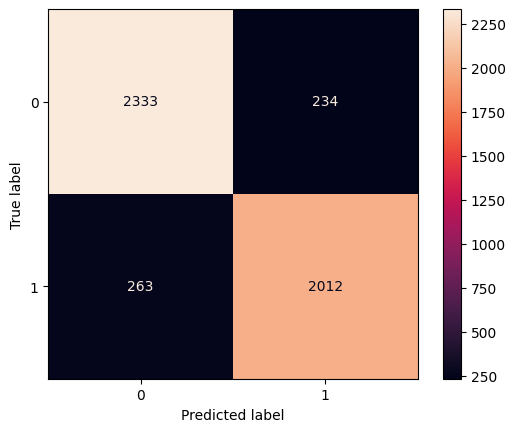

In [29]:
# Primeiro modelo: 
dat.target=dat.score.apply(lambda x: 0 if x<5 else 1)
print(f'Dimenções: {dat.shape}')
x_train,x_test,y_train,y_test = train_test_split(dat.review,dat.target, test_size=0.2, random_state=60)
pipe = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df=50,stop_words='english')),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())]).fit(x_train, y_train)
prediction = pipe.predict(x_test)
print(roc_auc_score(pipe.predict(x_train),y_train))
print(roc_auc_score(prediction,y_test))
plot_confusion_matrix(pipe,x_test,y_test,cmap='rocket')

In [30]:
!pip install spacy


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [31]:
!pip install textblob


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [32]:
!pip install nltk


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [33]:
from spacy.lang.en import English
from textblob import Word
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import nltk

In [34]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


KeyboardInterrupt: 

In [35]:

nlp = English()
def ProcessamentoDeTexto(texto): 
    '''
    input:a string
    usage: vectorize the vector and cuantify the string. Is possible add conditions compared to CountVectorizer()
    '''
    list_words = nlp(texto)
    sentence=[]
    
    # Removendo stopwords
    for token in list_words: 
        val=token.text.lower()# transformando em lowercase
        stop1=val in stopwords # stopwords especificadas no inicio do código
        stop2=nlp.vocab[val].is_stop #gerais
        if (not stop2) and (not stop1): sentence.append(val)
    filtered_sentence =[]

    #Lemmatize
    for val in sentence:  
        word = Word(val).lemmatize("n")
        word = Word(word).lemmatize("v")
        word = Word(word).lemmatize("a")
        word=WordNetLemmatizer().lemmatize(word,'v')
        filtered_sentence.append(word) 
    final_sentence=[]

    #Removendo algumas stopwords novamente
    for val in filtered_sentence:
        if not (val in stopwords): final_sentence.append(val) #Algumas stopwords especificas podem aparecer novamente; examplo:gamer to game
    final_sentence=' '.join(final_sentence)

    #Removendo pontuações e virgulas
    tokenizer = RegexpTokenizer(r'\w+')
    final_sentence=tokenizer.tokenize(final_sentence)  
    return ' '.join(final_sentence)


dat['pre_review']=dat.review.apply(ProcessamentoDeTexto)
vectorizer=CountVectorizer(analyzer = "word",min_df=50,stop_words='english')
feature_matrix = vectorizer.fit_transform(dat.pre_review).toarray()
features=pd.DataFrame(feature_matrix, columns=vectorizer.get_feature_names()) 


/Users/alessasantos/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Criando um WorldCloud

In [ ]:
!pip install plotly


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [36]:
import plotly.graph_objects as go

In [37]:
img = np.array(Image.open("./imagem/the-last-of-us-part-ii.jpeg"))

In [38]:
def GeradorWorldCloud(x,txt,show_table=True):
    '''
    input:a dataframe, the title, a boolean
    output: a worldcloud, (a summary table)
    '''
    # WorldCloud
    cloud = WordCloud(width=1640, height=1200,random_state=60,
                    stopwords=['think','kill','game','story','character','play','gameplay','good','end','like','ellie','joel','abby','nt','s','ll','n','t'],mask=img).generate(" ".join(x.pre_review))
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    plt.imshow(cloud)
    plt.axis('off')
    
    #Summary table
    if show_table==True:
        lst=x.review.iloc[:12].apply(lambda x: [' '+x[:100]+'\n'+x[100:200]+'\n'+x[200:300]+'...'])  
        tab=plt.table(cellText=list(lst), rowLabels=np.arange(12)+1, 
                  colLabels=[txt],colColours=['red'], loc='right',cellLoc='center',colLoc='center')
        tab.auto_set_font_size(False); tab.set_fontsize(14)
        tab.scale(1, 4)
        set_pad_for_column(tb=tab,col=0, pad=0.01) 
    plt.show() 

In [39]:
def SubplotWorldCloud(x):
    '''
    input:a dataframe
    output: a worldcloud
    obs: maybe is better combine this and generate world_cloud in a function, or in a class
    '''
    cloud = WordCloud(width=140, height=108,random_state=60,
                      stopwords=set(['think','kill','game','story','character','play','gameplay','good','end','like','ellie','joel','abby','nt','s','ll','n','t']), mask=img).generate(" ".join(x.pre_review))
    plt.imshow(cloud)
    plt.title(f'Score: {i}',loc='left')
    plt.axis('off')

In [48]:
def CriarReport(df):
    '''
    input: a dataframe
    output: return a table that shows its reviews and scores
    usage: filter the dataframe and obtain that specific report
    '''
    #Adicionando coreas por score
    fill_color = []; n = len(df)
    for i in range(n):  
        if df.iloc[i].label=='Bad review':fill_color.append('red')
        elif df.iloc[i].label=='Ok review':fill_color.append('orange')
        else:fill_color.append("green")
    #Plotando a figura
    fig = go.Figure(data=[  
        go.Table(columnorder = [1,2], columnwidth = [440,40],
      header=dict(values=['<b>Reviews</b>', '<b>Score</b>'],
        line_color='black', fill_color='black',
        align='center',font=dict(color='white', size=12)),
      cells=dict(values=[df.review, df.score],
        line_color=['black']*2,fill_color=[fill_color,fill_color],
        align='center', font=dict(color='black', size=11)))
    ])
    fig.show()

In [41]:
def set_pad_for_column(tb,col, pad=0.1):
    '''
    usage: fix the pad of a plt.table
    '''
    cells = tb.get_celld()
    column = [cell for cell in tb.get_celld() if cell[1] == col]
    for cell in column: cells[cell].PAD = pad

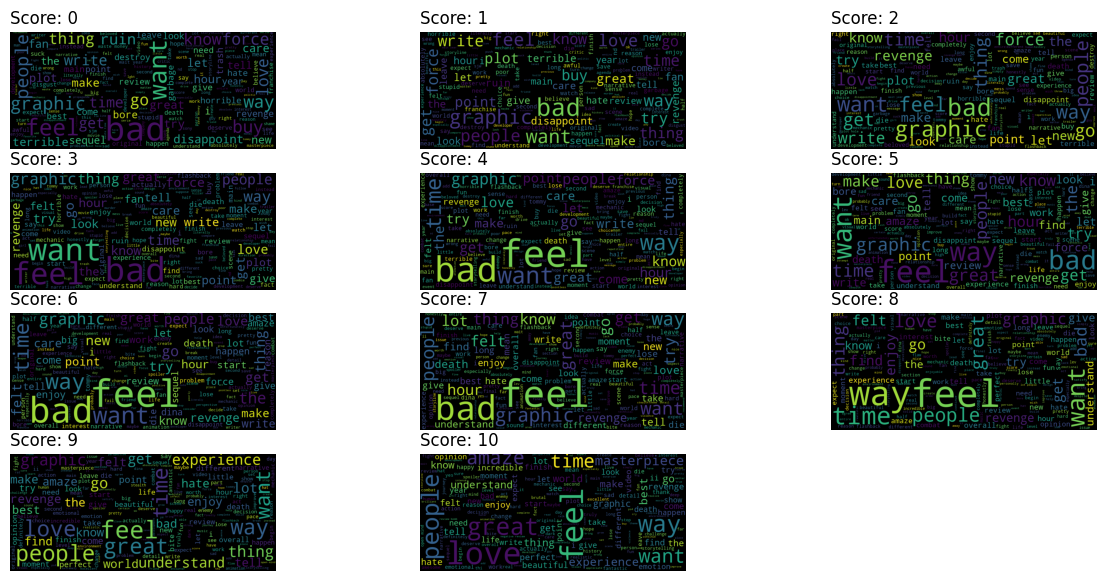

In [ ]:
fig = plt.figure(figsize=(15, 7))
for i in range(11): 
    plt.subplot(4,3,i+1)
    SubplotWorldCloud(dat[dat.score==i])

In [ ]:
dat.head()

,id,review,type_review,date,language,views,votes,score,sug,label,month,day_of_month,day_of_week,review_length,pre_review
0,Araset,"Well, it's most definetly sheeet and peess and...",expanded,2021-03-16,English,2,2,1,1.0,Bad review,March,16,Tuesday,79,definetly sheeet pee coom good
1,realistyalanci,"Pathetic.,Disappointment. Inconsistency.,Cring...",expanded,2021-03-16,English,3,3,0,1.0,Bad review,March,16,Tuesday,117,pathetic disappointment inconsistency cringe b...
2,wingZero21,I really enjoyed the first game. It was a 10/1...,normal,2021-03-14,English,2,2,6,1.0,Ok review,March,14,Sunday,2473,enjoy 10 10 unfortunately say second type heav...
3,echo360calix,This game is a very sad destruction of an amaz...,normal,2021-03-14,English,2,2,0,1.0,Bad review,March,14,Sunday,421,sad destruction amaze origin see sequel kill s...
4,sa674,"It’s a different game from part one, not bad o...",expanded,2021-03-13,English,2,2,2,1.0,Bad review,March,13,Saturday,110,different bad overall justification delay long


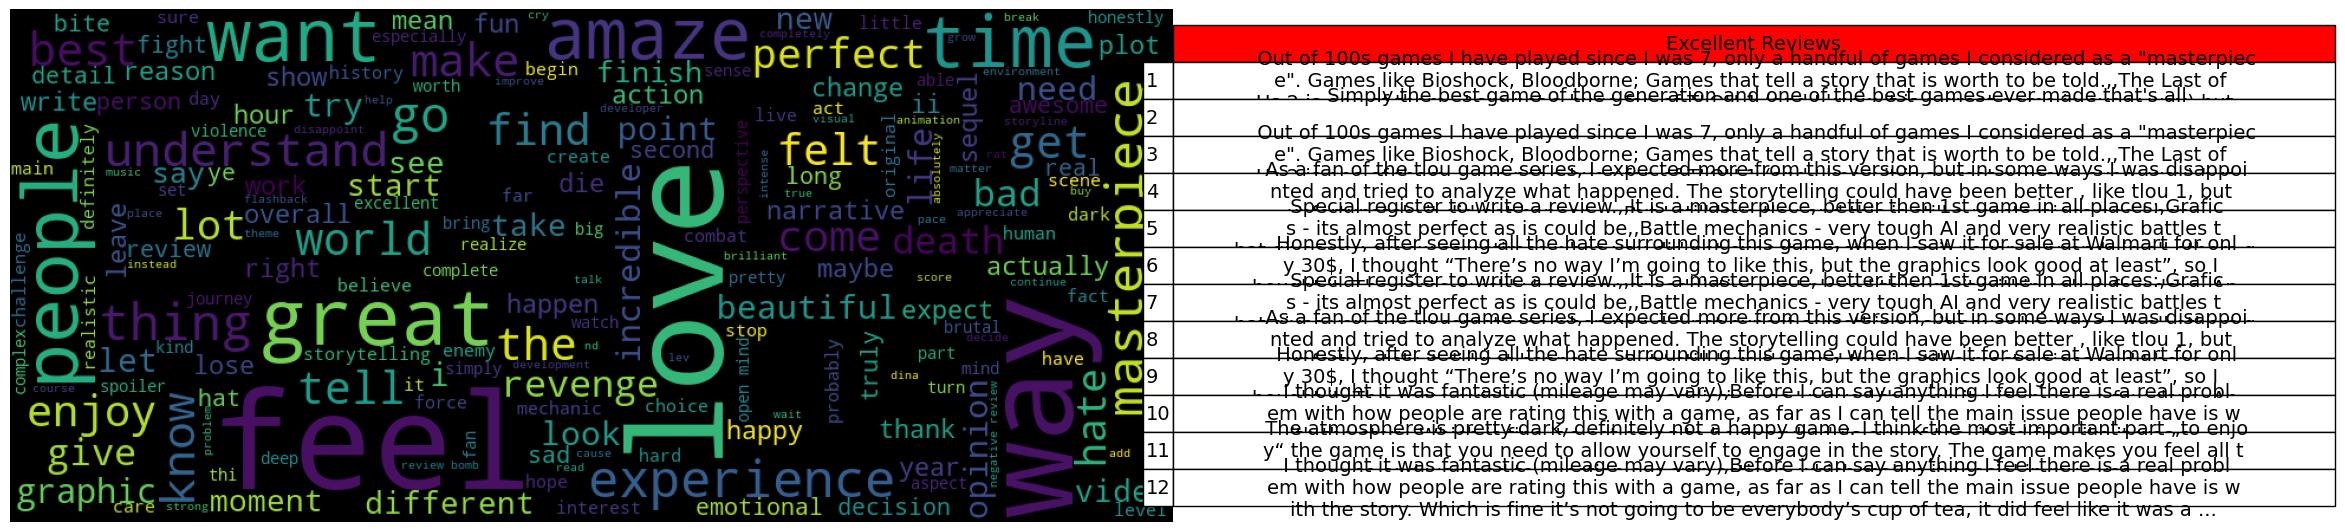

In [ ]:
GeradorWorldCloud(dat[dat.label=='Excellent review'],'Excellent Reviews') 

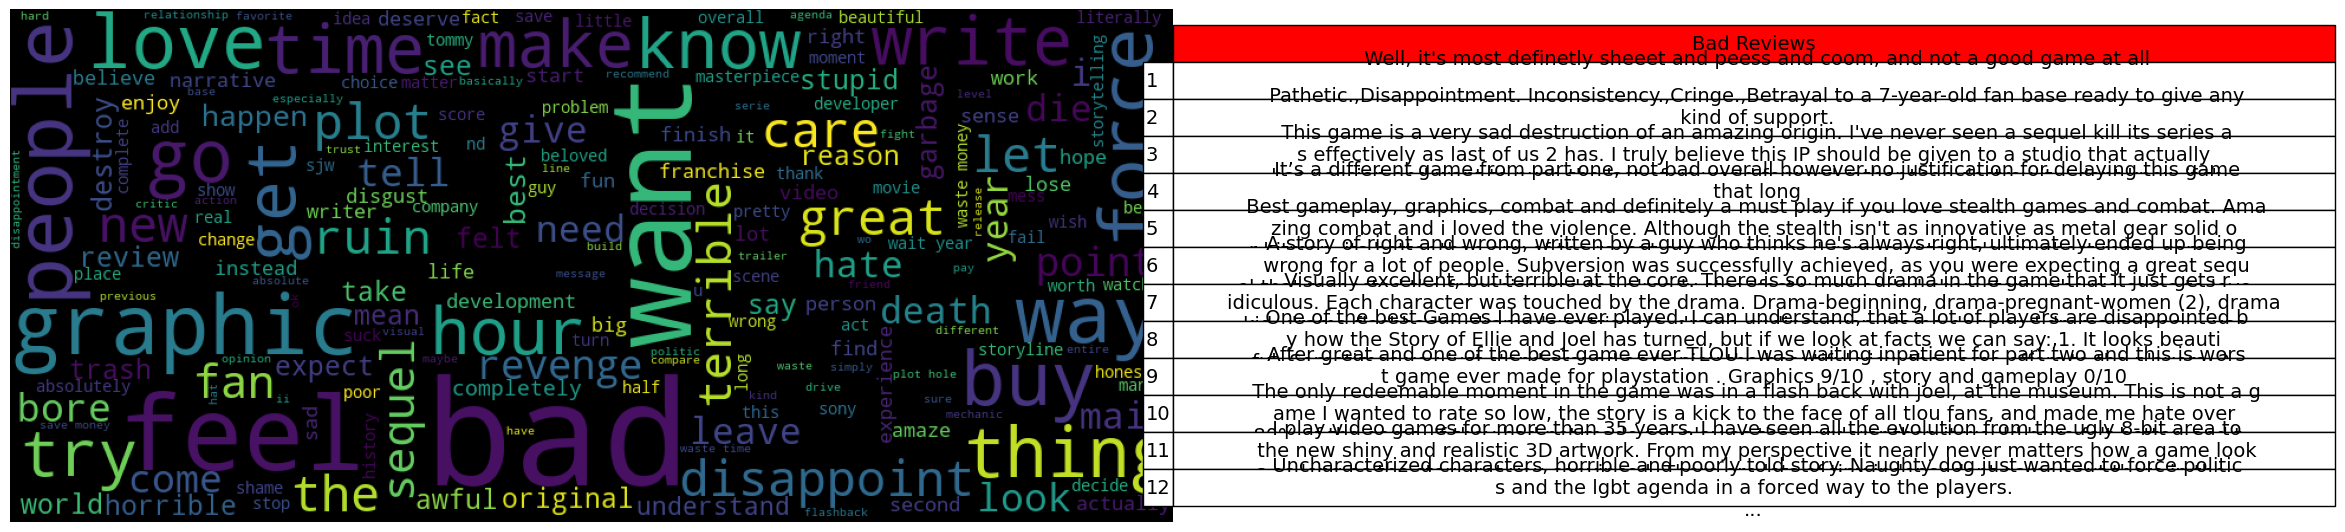

In [ ]:
GeradorWorldCloud(dat[dat.label=='Bad review'],'Bad Reviews') 


In [49]:
CriarReport(dat.iloc[:100]) 